In [ ]:
# Working environment informations;

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

Thu Jan  4 22:28:20 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   54C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/ACDC.zip

Archive:  /content/drive/MyDrive/ACDC.zip
   creating: ACDC/
  inflating: ACDC/desktop.ini        
   creating: ACDC/test/
   creating: ACDC/test/clear/
  inflating: ACDC/test/clear/clear_00.png  
  inflating: ACDC/test/clear/clear_01.png  
  inflating: ACDC/test/clear/clear_02.png  
  inflating: ACDC/test/clear/clear_03.png  
  inflating: ACDC/test/clear/clear_04.png  
  inflating: ACDC/test/clear/clear_05.png  
  inflating: ACDC/test/clear/clear_06.png  
  inflating: ACDC/test/clear/clear_07.png  
  inflating: ACDC/test/clear/clear_08.png  
  inflating: ACDC/test/clear/clear_09.png  
  inflating: ACDC/test/clear/clear_10.png  
  inflating: ACDC/test/clear/clear_11.png  
  inflating: ACDC/test/clear/clear_12.png  
  inflating: ACDC/test/clear/clear_13.png  
  inflating: ACDC/test/clear/clear_14.png  
  inflating: ACDC/test/clear/clear_15.png  
  inflating: ACDC/test/clear/clear_16.png  
  inflating: ACDC/test/clear/clear_17.png  
  inflating: ACDC/test/clear/clear_18.png  
  inflating

In [ ]:
!pip install git+https://www.github.com/keras-team/keras-contrib.git

  Cloning https://www.github.com/keras-team/keras-contrib.git to /tmp/pip-req-build-f1_p3ywf
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib.git /tmp/pip-req-build-f1_p3ywf
  Resolved https://www.github.com/keras-team/keras-contrib.git to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
  Created wheel for keras-contrib: filename=keras_contrib-2.0.8-py3-none-any.whl size=101055 sha256=cf61288f3ef51ade6cd27c835d864d52e0d20579d7d589fc67a367579a9cdc8f
  Stored in directory: /tmp/pip-ephem-wheel-cache-td5cued7/wheels/74/d5/f7/0245af7ac33d5b0c2e095688649916e4bf9a8d6b3362a849f5
Successfully built keras-contrib


In [ ]:
from keras_contrib.layers import InstanceNormalization

We use Instance Normalization in our third model, BUNTT.

In [ ]:
%matplotlib inline

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Activation, Dense, Flatten,BatchNormalization, Conv2D, MaxPooling2D, MaxPool2D,
    Dropout, Input, Concatenate, GlobalAveragePooling2D, Reshape, Multiply, GroupNormalization
)
from tensorflow.keras.optimizers import Adam, SGD, AdamW
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import (
    imagenet_utils, DenseNet121, VGG16, VGG19, MobileNet, MobileNetV2, Xception, EfficientNetB3
)
from tensorflow.keras import regularizers
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler
from tensorflow.keras.regularizers import l2

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

The modules required for CNN architecture are being imported.

In [ ]:
np.random.seed(2080284)

In [ ]:
img_rows = 128
img_cols = 128
batch_size = 32

train_dataset = '/content/ACDC/train'
test_dataset = '/content/ACDC/test'

train_datagen = ImageDataGenerator(rescale=1. / 255,
                                    horizontal_flip=True,
                                    fill_mode='nearest',
                                    rotation_range = 20,  # randomly rotate images in the range (degrees, 0 to 180)
                                    vertical_flip=False)  # randomly flip images

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(train_dataset,
                                                    target_size = (img_rows, img_cols),
                                                    batch_size = batch_size,
                                                    #color_mode = 'grayscale',
                                                    seed = 1903,
                                                    class_mode = 'categorical',
                                                    shuffle = True,
                                                    subset='training')

test_generator = test_datagen.flow_from_directory(test_dataset,
                                                  target_size = (img_rows, img_cols),
                                                  batch_size = batch_size,
                                                  #color_mode = 'grayscale',
                                                  shuffle = False, class_mode='categorical')

steps_per_epoch = (train_generator.samples) // batch_size
label_names = list(train_generator.class_indices.keys())

print("\nNumber of Training samples: ",train_generator.samples)
print("Number of Test samples: ", test_generator.samples)
print("\nLabel names: ",label_names)
print("\nSteps per epoch: ", steps_per_epoch)

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.

Number of Training samples:  1000
Number of Test samples:  500

Label names:  ['clear', 'fog', 'night', 'rain', 'snow']

Steps per epoch:  31


The rows and columns we have are converted to 128x128 size and divided into batches of 32.

All values are taken between 0 and 1 with rescale (1. /255). We add horizontal_flip and rotation_range to diversify the training dataset.

To calculate steps per epoch, we perform train_generator.samples // batch_size. We print the label names using the list(train_generator.class_indices.keys()) function.

In [ ]:
# Transfer learning with DenseNet

base_model=tf.keras.applications.DenseNet121(include_top=False, weights="imagenet",input_shape=(img_rows,img_cols,3), pooling='max')
base_model.trainable = False

learning_rate = 1e-5
x=base_model.output
x=BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001 )(x)
x = Dense(256, kernel_regularizer = regularizers.l2(l = 0.016),activity_regularizer=regularizers.l1(0.006),
                    bias_regularizer=regularizers.l1(0.006) ,activation='relu')(x)
#x=Dropout(rate=.4, seed=123)(x)

output=Dense(5, activation='softmax')(x)

model=Model(inputs=base_model.input, outputs=output)

model.summary()

29084464/29084464 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 134, 134, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 64, 64, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  

In [ ]:
#reduces learning rate if no significant decrease in loss for {{patience}} epochs.
RLROP = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1,min_lr=1e-8)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True
)

tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    write_grads=True,
    write_images=True,
)

csvlogger = CSVLogger(
    filename= "densenet_121.csv",
    separator = ",",
    append = False
)

#save best model
#path where highest valid accuracy will save
checkpoint_file = "densenet_121.hdf5"
#callback to save the best model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose = 1,
    save_best_only=True)

#adam, binary_crossentropy, accuracy
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

In [ ]:
history_densenet_121 = model.fit(
    train_generator,
    validation_data  = test_generator,
    epochs = 30, verbose = 1,
    callbacks = [RLROP, model_checkpoint_callback, csvlogger, tensorboard, early_stop]
)

Epoch 1/30
32/32 [==============================] - ETA: 0s - loss: 6.1933 - accuracy: 0.7690
Epoch 1: val_accuracy improved from -inf to 0.73200, saving model to densenet_121.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 45s 1s/step - loss: 6.1933 - accuracy: 0.7690 - val_loss: 5.4011 - val_accuracy: 0.7320 - lr: 0.0010
Epoch 2/30
32/32 [==============================] - ETA: 0s - loss: 3.5358 - accuracy: 0.9300
Epoch 2: val_accuracy improved from 0.73200 to 0.82000, saving model to densenet_121.hdf5
32/32 [==============================] - 30s 935ms/step - loss: 3.5358 - accuracy: 0.9300 - val_loss: 3.2061 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 3/30
32/32 [==============================] - ETA: 0s - loss: 2.2909 - accuracy: 0.9550
Epoch 3: val_accuracy improved from 0.82000 to 0.84400, saving model to densenet_121.hdf5
32/32 [==============================] - 25s 792ms/step - loss: 2.2909 - accuracy: 0.9550 - val_loss: 2.1688 - val_accuracy: 0.8440 - lr: 0.0010
Epoch 4/30
32/32 [==============================] - ETA: 0s - loss: 1.5823 - accuracy: 0.9560
Epoch 4: val_accuracy improved from 0.84400 to 0.85600, saving model to densenet_121.hdf5
32/32 [=========

We trained our DenseNet121 model

In [ ]:
#achieved local minima without overfitting.
#loading the best model
model.load_weights("/content/densenet_121.hdf5")

Last Epoch:

Training Accuracy    : 0.9819999933242798
Training Loss        : 0.43877026438713074
Validation Accuracy  : 0.8920000195503235
Validation Loss      : 0.6122590899467468

All Epochs:


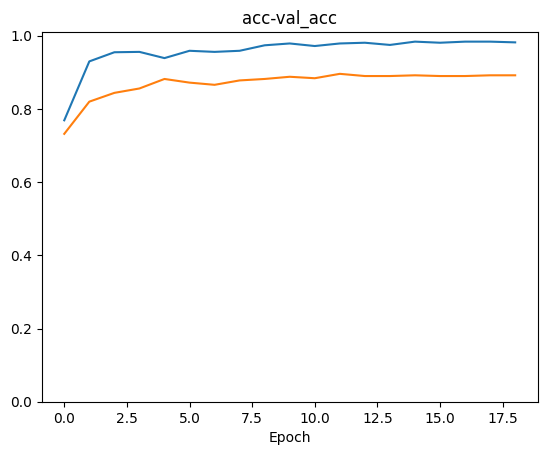

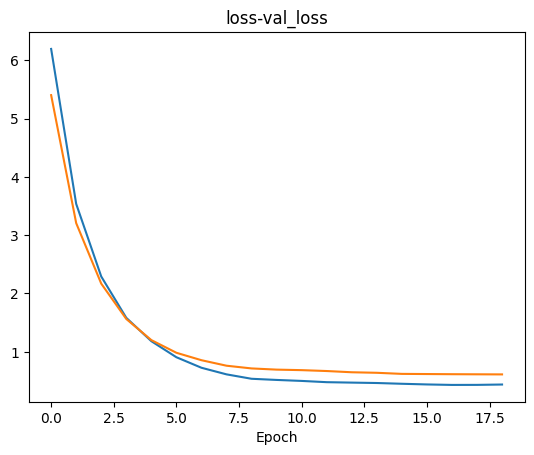



Classification Report

16/16 [==============================] - 8s 393ms/step
              precision    recall  f1-score   support

       clear     0.9709    1.0000    0.9852       100
         fog     0.8692    0.9300    0.8986       100
       night     1.0000    0.9600    0.9796       100
        rain     0.9275    0.6400    0.7574       100
        snow     0.7600    0.9500    0.8444       100

    accuracy                         0.8960       500
   macro avg     0.9055    0.8960    0.8930       500
weighted avg     0.9055    0.8960    0.8930       500


Confusion Matrix



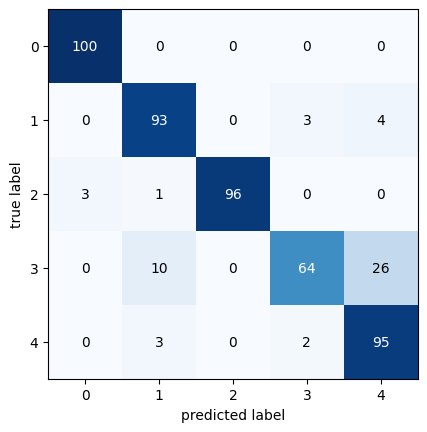

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

print("Last Epoch:\n")
model_accuracy_nas      = history_densenet_121.history['accuracy'][-1]
model_loss_nas          = history_densenet_121.history['loss'][-1]
model_val_accuracy_nas    = history_densenet_121.history['val_accuracy'][-1]
model_val_loss_nas        = history_densenet_121.history['val_loss'][-1]
print("Training Accuracy    :", model_accuracy_nas )
print("Training Loss        :", model_loss_nas)
print("Validation Accuracy  :", model_val_accuracy_nas )
print("Validation Loss      :", model_val_loss_nas)

print("\nAll Epochs:")
def plot_history_acc():
    plt.figure()
    plt.xlabel('Epoch')
    plt.title("acc-val_acc")
    plt.axis([None, None, 0, 1.01])
    plt.plot(history_densenet_121.history['accuracy'])
    plt.plot(history_densenet_121.history['val_accuracy'])
    plt.show()

def plot_history_loss():
    plt.figure()
    plt.xlabel('Epoch')
    plt.title("loss-val_loss")
    plt.axis([None, None, None, None])
    plt.plot(history_densenet_121.history['loss'])
    plt.plot(history_densenet_121.history['val_loss'])
    plt.show()

plot_history_acc()
plot_history_loss()

print("\n=============================================================================================\n")
print('Classification Report\n')
Y_pred_model = model.predict(test_generator, test_generator.samples // batch_size+1)
y_pred_model = np.argmax(Y_pred_model, axis=1)
class_rep_model = classification_report(test_generator.classes, y_pred_model, target_names=label_names, digits=4)
print(class_rep_model)

print('\nConfusion Matrix\n')
conf_matrix_model = confusion_matrix(test_generator.classes, y_pred_model)
cm_model = np.array2string(conf_matrix_model)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix_model)
plt.show()

DenseNet is a pre-trained model. We create and train our own network using this model. The purpose of this is to make comparisons with other models.

In [ ]:
modelBUN3 = tf.keras.Sequential([
    Conv2D(16, kernel_size=3, activation='relu', input_shape=(128,128,3), padding = "SAME"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(32, kernel_size=3, activation='relu', padding = "SAME"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(64, kernel_size=3, activation='relu', padding = "SAME"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(128, kernel_size=3, activation='relu', padding = "SAME"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(256, kernel_size=3, activation='relu', padding = "SAME"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(512, kernel_size=3, activation='relu', padding = "SAME"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Conv2D(1024, kernel_size=3, activation='relu', padding = "SAME"),
    BatchNormalization(),
    MaxPool2D(pool_size=(2,2)),
    Flatten(),
    Dense(128, activation = "relu"),
    Dropout(0.5),
    Dense(5, activation = "softmax")
])

In [ ]:
#reduces learning rate if no significant decrease in loss for {{patience}} epochs.
RLROP = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1,min_lr=1e-9)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=9,
    restore_best_weights=True
)

tensorboard = TensorBoard(
    log_dir = './logs_bun',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    write_grads=True,
    write_images=True,
)

csvlogger = CSVLogger(
    filename= "bun_model.csv",
    separator = ",",
    append = False
)

#save best model
#path where highest valid accuracy will save
checkpoint_file = "bun_model.hdf5"
#callback to save the best model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose = 1,
    save_best_only=True)

#adam, binary_crossentropy, accuracy
modelBUN3.compile(loss='categorical_crossentropy', optimizer=Adam(1e-5), metrics=['accuracy'])
modelBUN3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_14 (Conv2D)          (None, 128, 128, 16)      448       
                                                                 
 batch_normalization_15 (Ba  (None, 128, 128, 16)      64        
 tchNormalization)                                               
                                                                 
 max_pooling2d_14 (MaxPooli  (None, 64, 64, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 32)        4640      
                                                                 
 batch_normalization_16 (Ba  (None, 64, 64, 32)        128       
 tchNormalization)                                               
                                                      

In [ ]:
history_bun3 = modelBUN3.fit(
    train_generator,
    validation_data  = test_generator,
    epochs = 50, verbose = 1,
    callbacks = [RLROP, model_checkpoint_callback, csvlogger, tensorboard, early_stop]
)

Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 1.7630 - accuracy: 0.4840
Epoch 1: val_accuracy improved from -inf to 0.20000, saving model to bun_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 29s 758ms/step - loss: 1.7630 - accuracy: 0.4840 - val_loss: 1.6154 - val_accuracy: 0.2000 - lr: 1.0000e-05
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 0.8200 - accuracy: 0.7270
Epoch 2: val_accuracy did not improve from 0.20000
32/32 [==============================] - 24s 759ms/step - loss: 0.8200 - accuracy: 0.7270 - val_loss: 1.6428 - val_accuracy: 0.2000 - lr: 1.0000e-05
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 0.6062 - accuracy: 0.7980
Epoch 3: val_accuracy did not improve from 0.20000
32/32 [==============================] - 27s 853ms/step - loss: 0.6062 - accuracy: 0.7980 - val_loss: 1.7255 - val_accuracy: 0.2000 - lr: 1.0000e-05
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 0.5536 - accuracy: 0.8070
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.

Epoch 4: val_accuracy did not improve from 0.20000
32/32 [==============================] - 

We increased the number of epochs (from 30 to 50)
The reason for this is to extend the time so that it can be a train since it is a late train.

Last Epoch:

Training Accuracy    : 0.8560000061988831
Training Loss        : 0.39910122752189636
Validation Accuracy  : 0.8560000061988831
Validation Loss      : 0.4204504191875458

All Epochs:


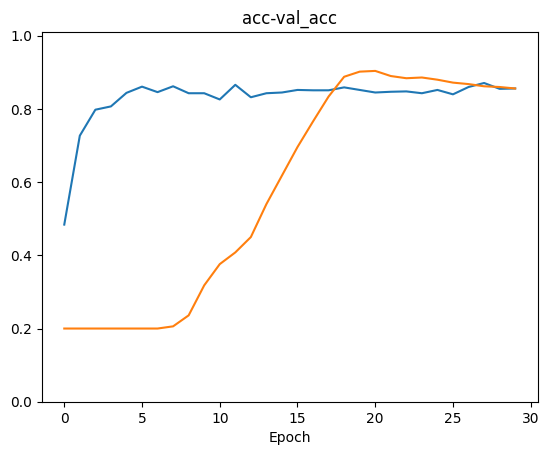

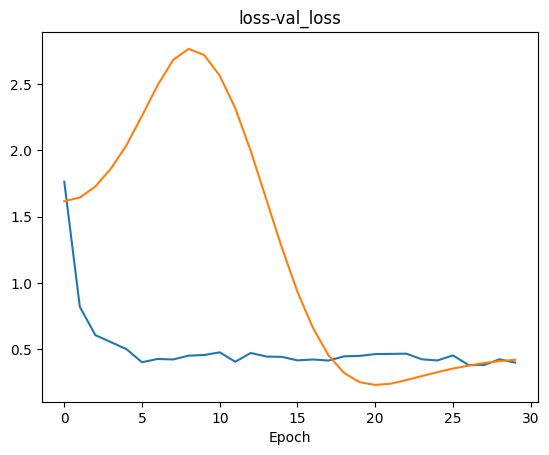



Classification Report

16/16 [==============================] - 7s 406ms/step
              precision    recall  f1-score   support

       clear     0.9596    0.9500    0.9548       100
         fog     0.9263    0.8800    0.9026       100
       night     0.9897    0.9600    0.9746       100
        rain     0.8462    0.8800    0.8627       100
        snow     0.8095    0.8500    0.8293       100

    accuracy                         0.9040       500
   macro avg     0.9063    0.9040    0.9048       500
weighted avg     0.9063    0.9040    0.9048       500


Confusion Matrix



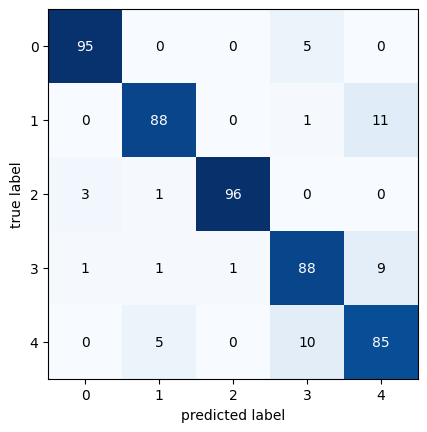

In [ ]:
print("Last Epoch:\n")
model_accuracy_nas      = history_bun3.history['accuracy'][-1]
model_loss_nas          = history_bun3.history['loss'][-1]
model_val_accuracy_nas    = history_bun3.history['val_accuracy'][-1]
model_val_loss_nas        = history_bun3.history['val_loss'][-1]
print("Training Accuracy    :", model_accuracy_nas )
print("Training Loss        :", model_loss_nas)
print("Validation Accuracy  :", model_val_accuracy_nas )
print("Validation Loss      :", model_val_loss_nas)

print("\nAll Epochs:")
def plot_history_acc():
    plt.figure()
    plt.xlabel('Epoch')
    plt.title("acc-val_acc")
    plt.axis([None, None, 0, 1.01])
    plt.plot(history_bun3.history['accuracy'])
    plt.plot(history_bun3.history['val_accuracy'])
    plt.show()

def plot_history_loss():
    plt.figure()
    plt.xlabel('Epoch')
    plt.title("loss-val_loss")
    plt.axis([None, None, None, None])
    plt.plot(history_bun3.history['loss'])
    plt.plot(history_bun3.history['val_loss'])
    plt.show()

plot_history_acc()
plot_history_loss()

print("\n=============================================================================================\n")
print('Classification Report\n')
Y_pred_model = modelBUN3.predict(test_generator, test_generator.samples // batch_size+1)
y_pred_model = np.argmax(Y_pred_model, axis=1)
class_rep_model = classification_report(test_generator.classes, y_pred_model, target_names=label_names, digits=4)
print(class_rep_model)

print('\nConfusion Matrix\n')
conf_matrix_model = confusion_matrix(test_generator.classes, y_pred_model)
cm_model = np.array2string(conf_matrix_model)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix_model)
plt.show()


In [ ]:
def se_block(residual, name, ratio=8):
  """Contains the implementation of Squeeze-and-Excitation(SE) block in TF 2.
  As described in https://arxiv.org/abs/1709.01507.
  """

  channel = residual.shape[-1]

  with tf.name_scope(name):
    # Global average pooling
    squeeze = tf.reduce_mean(residual, axis=[1,2], keepdims=True)

    excitation = tf.keras.layers.Dense(units=channel//ratio, activation='relu')(squeeze)
    excitation = tf.keras.layers.Dense(units=channel, activation='sigmoid')(excitation)

    scale = residual * excitation

  return scale

def channel_attention(input_feature, name, ratio=8):

  channel = input_feature.shape[-1]

  with tf.name_scope(name):

    avg_pool = tf.reduce_mean(input_feature, axis=[1,2], keepdims=True)
    avg_pool = tf.keras.layers.Dense(units=channel//ratio, activation='relu')(avg_pool)
    avg_pool = tf.keras.layers.Dense(units=channel)(avg_pool)

    max_pool = tf.reduce_max(input_feature, axis=[1,2], keepdims=True)
    max_pool = tf.keras.layers.Dense(units=channel//ratio, activation='relu')(max_pool)
    max_pool = tf.keras.layers.Dense(units=channel)(max_pool)

    scale = tf.sigmoid(avg_pool + max_pool)

  return input_feature * scale

def spatial_attention(input_feature, name):

  with tf.name_scope(name):

    avg_pool = tf.reduce_mean(input_feature, axis=[3], keepdims=True)
    max_pool = tf.reduce_max(input_feature, axis=[3], keepdims=True)

    concat = tf.concat([avg_pool,max_pool], axis=-1)

    concat = tf.keras.layers.Conv2D(filters=1, kernel_size=[7,7], strides=[1,1], padding="same", use_bias=False)(concat)
    concat = tf.sigmoid(concat)

  return input_feature * concat

def cbam_block(input_feature, name, ratio=8):
  """Contains TF 2 implementation of Convolutional Block Attention Module(CBAM) block.
  As described in https://arxiv.org/abs/1807.06521.
  """

  with tf.name_scope(name):
    attention_feature = channel_attention(input_feature, 'ch_at', ratio)
    attention_feature = spatial_attention(attention_feature, 'sp_at')

  return attention_feature

In [ ]:
inputs = tf.keras.Input(shape=(128, 128, 3))
x = Conv2D(16, kernel_size=3, activation='relu', padding="SAME")(inputs)
x = cbam_block(x,"a1")
x = InstanceNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(32, kernel_size=3, activation='relu', padding="SAME")(x)
x = cbam_block(x,"a2")
x = InstanceNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(64, kernel_size=3, activation='relu', padding="SAME")(x)
x = cbam_block(x,"a3")
x = InstanceNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(128, kernel_size=3, activation='relu', padding="SAME")(x)
x = cbam_block(x,"a4")
x = InstanceNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(256, kernel_size=3, activation='relu', padding="SAME")(x)
x = cbam_block(x,"a5")
x = InstanceNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(512, kernel_size=3, activation='relu', padding="SAME")(x)
x = cbam_block(x,"a6")
x = InstanceNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Conv2D(1024, kernel_size=3, activation='relu', padding="SAME")(x)
x = cbam_block(x,"a7")
x = InstanceNormalization()(x)
x = MaxPool2D(pool_size=(2, 2))(x)
x = Flatten()(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(128, activation="relu")(x)
x = Dropout(0.2)(x)
outputs = Dense(5, activation="softmax")(x)

modelBUNTT = tf.keras.Model(inputs=inputs, outputs=outputs)

In [ ]:
#reduces learning rate if no significant decrease in loss for {{patience}} epochs.
RLROP = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy',patience=3,verbose=1,factor=0.1,min_lr=1e-9)

early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=9,
    restore_best_weights=True
)

tensorboard = TensorBoard(
    log_dir = './logs_buntt',
    histogram_freq=0,
    batch_size=32,
    write_graph=True,
    write_grads=True,
    write_images=True,
)

csvlogger = CSVLogger(
    filename= "buntt_model.csv",
    separator = ",",
    append = False
)

#save best model
#path where highest valid accuracy will save
checkpoint_file = "buntt_model.hdf5"
#callback to save the best model
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max', verbose = 1,
    save_best_only=True)

#adam, binary_crossentropy, accuracy
modelBUNTT.compile(loss='categorical_crossentropy',optimizer=Adam(1e-4), metrics=['accuracy'])
modelBUNTT.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d_21 (Conv2D)          (None, 128, 128, 16)         448       ['input_2[0][0]']             
                                                                                                  
 tf.math.reduce_mean (TFOpL  (None, 1, 1, 16)             0         ['conv2d_21[0][0]']           
 ambda)                                                                                           
                                                                                                  
 tf.math.reduce_max (TFOpLa  (None, 1, 1, 16)             0         ['conv2d_21[0][0]']     

In [ ]:
history_buntt = modelBUNTT.fit(
    train_generator,
    validation_data = test_generator,
    epochs = 50, verbose = 1,
    callbacks = [RLROP, model_checkpoint_callback, csvlogger, tensorboard, early_stop]
)

Epoch 1/50
32/32 [==============================] - ETA: 0s - loss: 1.2055 - accuracy: 0.5440
Epoch 1: val_accuracy improved from -inf to 0.79000, saving model to buntt_model.hdf5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


32/32 [==============================] - 49s 915ms/step - loss: 1.2055 - accuracy: 0.5440 - val_loss: 0.6157 - val_accuracy: 0.7900 - lr: 1.0000e-04
Epoch 2/50
32/32 [==============================] - ETA: 0s - loss: 0.7663 - accuracy: 0.6760
Epoch 2: val_accuracy did not improve from 0.79000
32/32 [==============================] - 28s 878ms/step - loss: 0.7663 - accuracy: 0.6760 - val_loss: 0.8372 - val_accuracy: 0.7000 - lr: 1.0000e-04
Epoch 3/50
32/32 [==============================] - ETA: 0s - loss: 0.6131 - accuracy: 0.7720
Epoch 3: val_accuracy improved from 0.79000 to 0.87000, saving model to buntt_model.hdf5
32/32 [==============================] - 28s 891ms/step - loss: 0.6131 - accuracy: 0.7720 - val_loss: 0.3960 - val_accuracy: 0.8700 - lr: 1.0000e-04
Epoch 4/50
32/32 [==============================] - ETA: 0s - loss: 0.4622 - accuracy: 0.8370
Epoch 4: val_accuracy improved from 0.87000 to 0.87200, saving model to buntt_model.hdf5
32/32 [==============================] - 2

Last Epoch:

Training Accuracy    : 0.9470000267028809
Training Loss        : 0.14217838644981384
Validation Accuracy  : 0.8960000276565552
Validation Loss      : 0.40255120396614075

All Epochs:


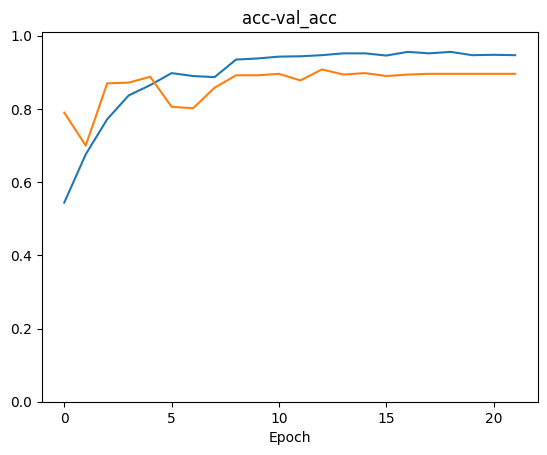

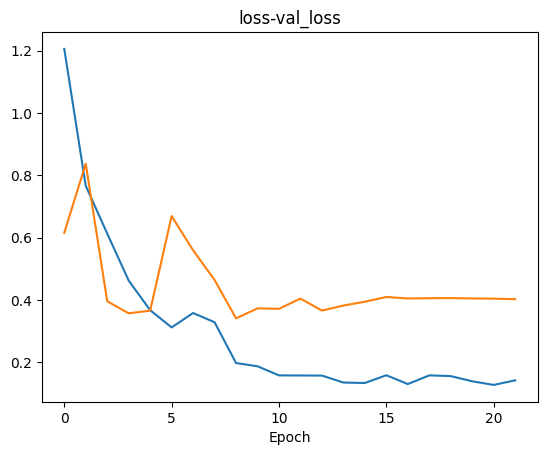



Classification Report

16/16 [==============================] - 7s 389ms/step
              precision    recall  f1-score   support

       clear     0.8919    0.9900    0.9384       100
         fog     0.9659    0.8500    0.9043       100
       night     0.9792    0.9400    0.9592       100
        rain     0.8214    0.9200    0.8679       100
        snow     0.9032    0.8400    0.8705       100

    accuracy                         0.9080       500
   macro avg     0.9123    0.9080    0.9080       500
weighted avg     0.9123    0.9080    0.9080       500


Confusion Matrix



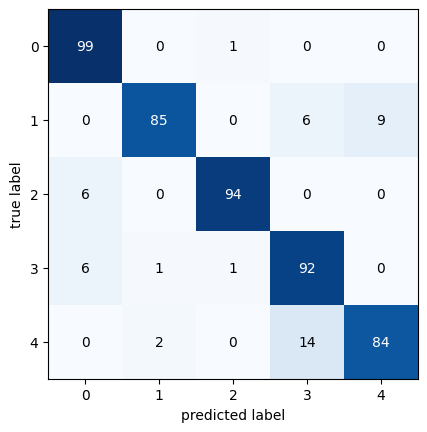

In [ ]:
print("Last Epoch:\n")
model_accuracy_nas      = history_buntt.history['accuracy'][-1]
model_loss_nas          = history_buntt.history['loss'][-1]
model_val_accuracy_nas    = history_buntt.history['val_accuracy'][-1]
model_val_loss_nas        = history_buntt.history['val_loss'][-1]
print("Training Accuracy    :", model_accuracy_nas )
print("Training Loss        :", model_loss_nas)
print("Validation Accuracy  :", model_val_accuracy_nas )
print("Validation Loss      :", model_val_loss_nas)

print("\nAll Epochs:")
def plot_history_acc():
    plt.figure()
    plt.xlabel('Epoch')
    plt.title("acc-val_acc")
    plt.axis([None, None, 0, 1.01])
    plt.plot(history_buntt.history['accuracy'])
    plt.plot(history_buntt.history['val_accuracy'])
    plt.show()

def plot_history_loss():
    plt.figure()
    plt.xlabel('Epoch')
    plt.title("loss-val_loss")
    plt.axis([None, None, None, None])
    plt.plot(history_buntt.history['loss'])
    plt.plot(history_buntt.history['val_loss'])
    plt.show()

plot_history_acc()
plot_history_loss()

print("\n=============================================================================================\n")
print('Classification Report\n')
Y_pred_model = modelBUNTT.predict(test_generator, test_generator.samples // batch_size+1)
y_pred_model = np.argmax(Y_pred_model, axis=1)
class_rep_model = classification_report(test_generator.classes, y_pred_model, target_names=label_names, digits=4)
print(class_rep_model)

print('\nConfusion Matrix\n')
conf_matrix_model = confusion_matrix(test_generator.classes, y_pred_model)
cm_model = np.array2string(conf_matrix_model)
fig, ax = plot_confusion_matrix(conf_mat=conf_matrix_model)
plt.show()


BUNTT is different from other models.We use Instance Normalization instead of Batch Normalization, we use CBAM block instead of SE block(cbam block is better than se block) As a result, at our third model (BUNTT), gave the best accuracy and loss values.
